# Fachprojekt Machine Learning
**Authors:** Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 3. July 2024

## Import necessary components

In [1]:
# Import the necessary libraries
import time, warnings, random
import torch, torch.nn.functional as F
from tabulate import tabulate
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the VAE model and functions
import networks
from datasets import create_datasets
from evaluation import evaluate
from interpolation import interpolate
from sampling import plot_reconstruction
from plotting import plot_loss_lr, plot_loss_components

## Set hyperparameters, loss function and optimizing tools

In [2]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 30 # One epoch means seeing every image of the training dataset
latent_dim = 256  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
learning_rate = 2e-5 # Determines how drastically the parameters of the network change
output_frequency = 150 # Determines how often the training progress will be logged (in batches)
number_embedding_vectors = 100
embedding_dimension = 128
beta = 0.1

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VQVAE(input_channels=input_channels, emb_dim=embedding_dimension, n_embed=number_embedding_vectors, beta=beta)
model.to(device)

# Loss function
def loss_function(recon_x, x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss + vq_loss, recon_loss, vq_loss

# Optimizer selection
optimizer_option = 'adam'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'exponential'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


## Choose a dataset for training

100%|██████████| 170498071/170498071 [00:18<00:00, 9233530.14it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


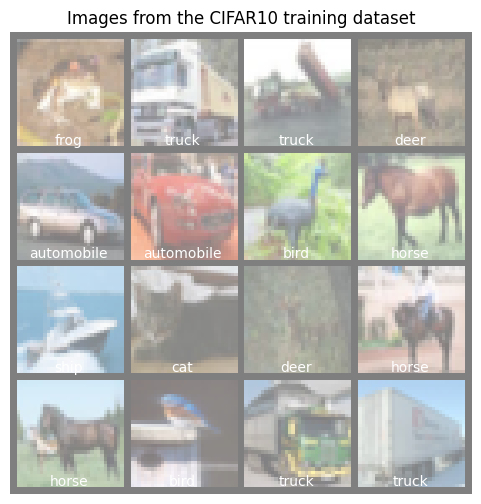

In [3]:
# Create and visualize the datasets for MNIST / CIFAR10
dataset_name = 'CIFAR10'
train_loader, test_loader = create_datasets(dataset_name, batch_size)

## Training loop

-----------------------------------------------------------------------------------------------------------------------------
Epoch:  1/ 30  Batch:    1  Total Loss:  43260.8  VQ Loss:  0.80198  Recon Loss:  43260  Commitment Loss:  0.729073  Embedding Loss:  0.729073  LR:  2e-05
Epoch:  1/ 30  Batch:  151  Total Loss:  5451.99  VQ Loss:  1.71691  Recon Loss:  5450.27  Commitment Loss:  1.56083  Embedding Loss:  1.56083  LR:  2e-05
Epoch:  1/ 30  Batch:  301  Total Loss:  3445.15  VQ Loss:  1.78495  Recon Loss:  3443.36  Commitment Loss:  1.62268  Embedding Loss:  1.62268  LR:  2e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       1 │          4743.04 │ 9.44s  │
╘═════════╧══════════════════╧════════╛


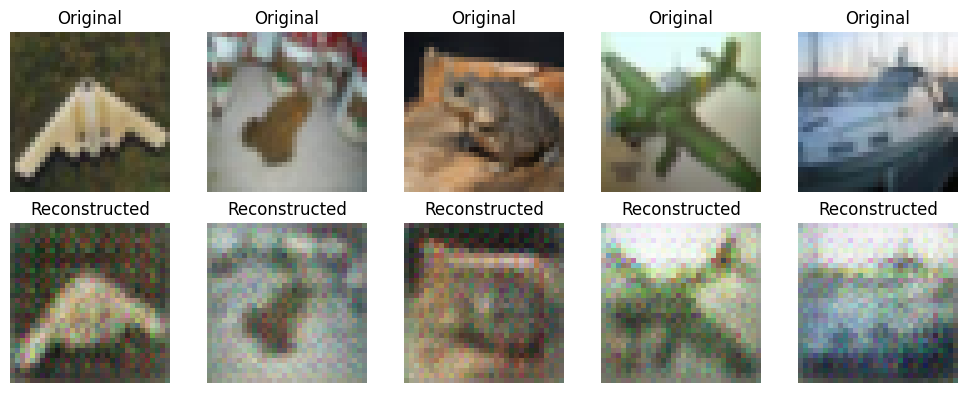

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  2/ 30  Batch:    1  Total Loss:  2764.96  VQ Loss:  1.899  Recon Loss:  2763.06  Commitment Loss:  1.72636  Embedding Loss:  1.72636  LR:  1.8e-05
Epoch:  2/ 30  Batch:  151  Total Loss:  2492.8  VQ Loss:  1.8663  Recon Loss:  2490.94  Commitment Loss:  1.69664  Embedding Loss:  1.69664  LR:  1.8e-05
Epoch:  2/ 30  Batch:  301  Total Loss:  2054.3  VQ Loss:  1.9047  Recon Loss:  2052.4  Commitment Loss:  1.73154  Embedding Loss:  1.73154  LR:  1.8e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       2 │          3334.06 │ 6.49s  │
╘═════════╧══════════════════╧════════╛


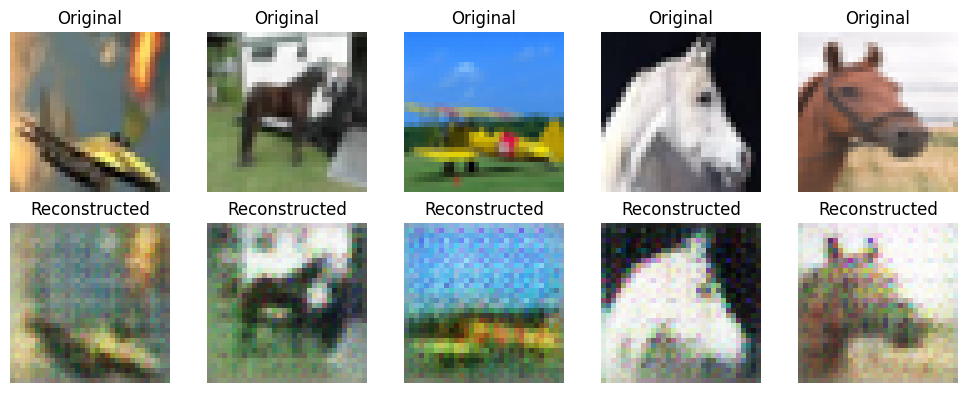

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  3/ 30  Batch:    1  Total Loss:  2033.75  VQ Loss:  1.94633  Recon Loss:  2031.8  Commitment Loss:  1.76939  Embedding Loss:  1.76939  LR:  1.62e-05
Epoch:  3/ 30  Batch:  151  Total Loss:  1660.26  VQ Loss:  1.91567  Recon Loss:  1658.34  Commitment Loss:  1.74152  Embedding Loss:  1.74152  LR:  1.62e-05
Epoch:  3/ 30  Batch:  301  Total Loss:  1544.25  VQ Loss:  2.00419  Recon Loss:  1542.24  Commitment Loss:  1.82199  Embedding Loss:  1.82199  LR:  1.62e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       3 │             2634 │ 6.45s  │
╘═════════╧══════════════════╧════════╛


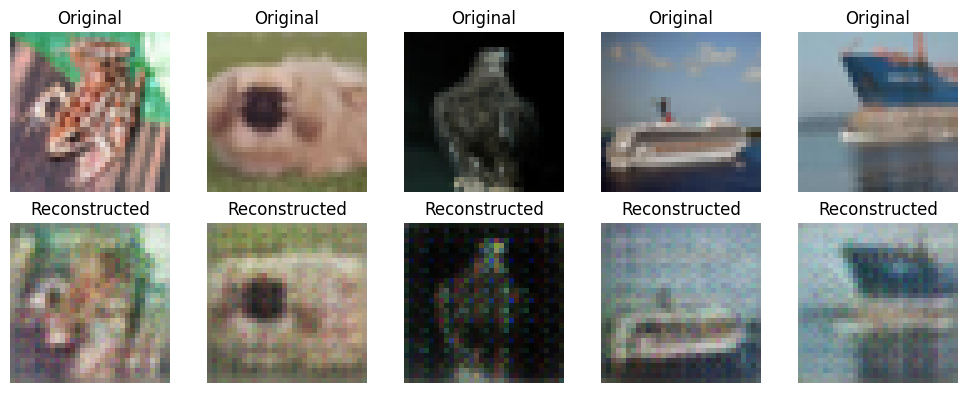

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  4/ 30  Batch:    1  Total Loss:  1439.27  VQ Loss:  2.01336  Recon Loss:  1437.26  Commitment Loss:  1.83033  Embedding Loss:  1.83033  LR:  1.458e-05
Epoch:  4/ 30  Batch:  151  Total Loss:  1475.4  VQ Loss:  2.07358  Recon Loss:  1473.33  Commitment Loss:  1.88507  Embedding Loss:  1.88507  LR:  1.458e-05
Epoch:  4/ 30  Batch:  301  Total Loss:  1354.42  VQ Loss:  2.05829  Recon Loss:  1352.37  Commitment Loss:  1.87117  Embedding Loss:  1.87117  LR:  1.458e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       4 │          2263.02 │ 6.25s  │
╘═════════╧══════════════════╧════════╛


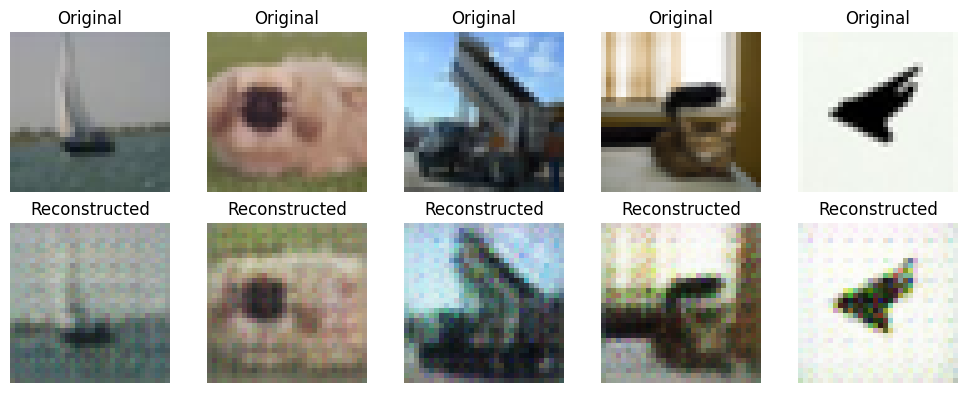

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  5/ 30  Batch:    1  Total Loss:  1241.26  VQ Loss:  2.04994  Recon Loss:  1239.21  Commitment Loss:  1.86358  Embedding Loss:  1.86358  LR:  1.3122e-05
Epoch:  5/ 30  Batch:  151  Total Loss:  1269.58  VQ Loss:  2.07101  Recon Loss:  1267.5  Commitment Loss:  1.88273  Embedding Loss:  1.88273  LR:  1.3122e-05
Epoch:  5/ 30  Batch:  301  Total Loss:  1139.98  VQ Loss:  2.04266  Recon Loss:  1137.94  Commitment Loss:  1.85696  Embedding Loss:  1.85696  LR:  1.3122e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       5 │          2212.34 │ 6.42s  │
╘═════════╧══════════════════╧════════╛


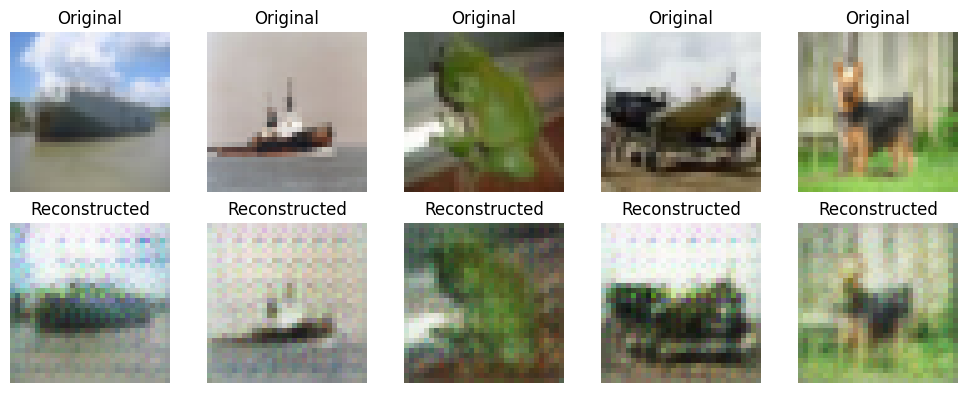

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  6/ 30  Batch:    1  Total Loss:  1044.76  VQ Loss:  2.09572  Recon Loss:  1042.67  Commitment Loss:  1.9052  Embedding Loss:  1.9052  LR:  1.18098e-05
Epoch:  6/ 30  Batch:  151  Total Loss:  1239.62  VQ Loss:  2.12092  Recon Loss:  1237.5  Commitment Loss:  1.92811  Embedding Loss:  1.92811  LR:  1.18098e-05
Epoch:  6/ 30  Batch:  301  Total Loss:  1005.6  VQ Loss:  2.11451  Recon Loss:  1003.48  Commitment Loss:  1.92228  Embedding Loss:  1.92228  LR:  1.18098e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       6 │          1937.63 │ 6.34s  │
╘═════════╧══════════════════╧════════╛


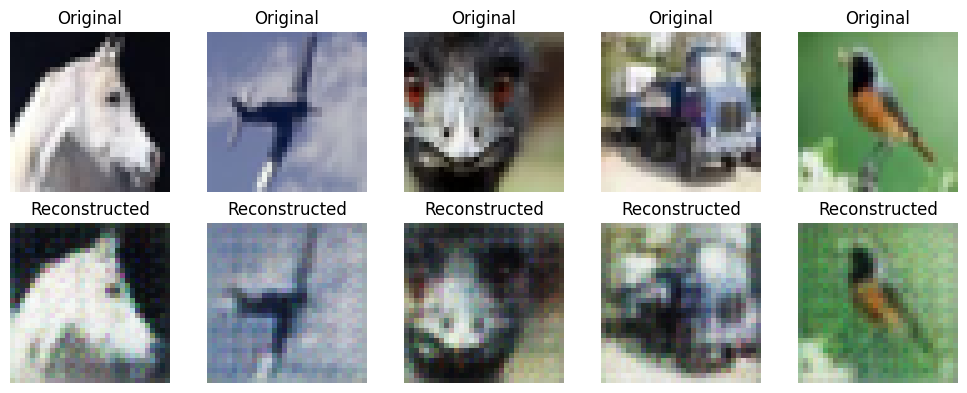

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  7/ 30  Batch:    1  Total Loss:  1096.63  VQ Loss:  2.11933  Recon Loss:  1094.51  Commitment Loss:  1.92667  Embedding Loss:  1.92667  LR:  1.06288e-05
Epoch:  7/ 30  Batch:  151  Total Loss:  911  VQ Loss:  2.08642  Recon Loss:  908.914  Commitment Loss:  1.89674  Embedding Loss:  1.89674  LR:  1.06288e-05
Epoch:  7/ 30  Batch:  301  Total Loss:  1024.97  VQ Loss:  2.04541  Recon Loss:  1022.92  Commitment Loss:  1.85946  Embedding Loss:  1.85946  LR:  1.06288e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       7 │          1996.11 │ 6.66s  │
╘═════════╧══════════════════╧════════╛


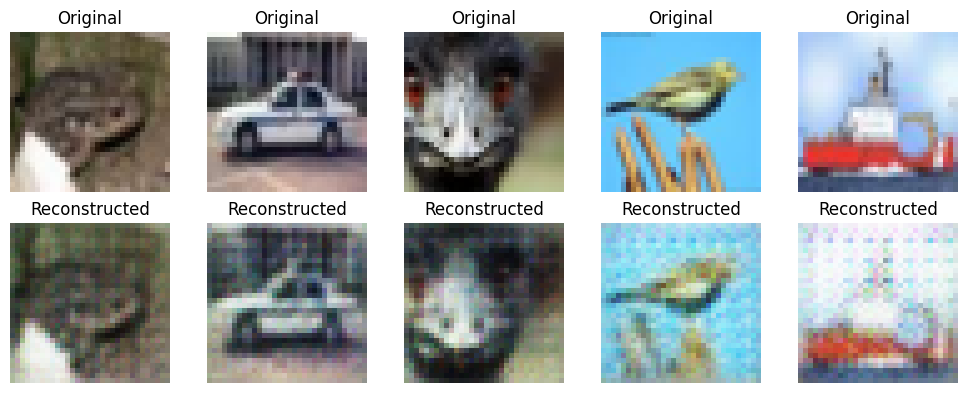

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  8/ 30  Batch:    1  Total Loss:  937.28  VQ Loss:  2.09754  Recon Loss:  935.182  Commitment Loss:  1.90685  Embedding Loss:  1.90685  LR:  9.56594e-06
Epoch:  8/ 30  Batch:  151  Total Loss:  1030.03  VQ Loss:  2.08123  Recon Loss:  1027.95  Commitment Loss:  1.89203  Embedding Loss:  1.89203  LR:  9.56594e-06
Epoch:  8/ 30  Batch:  301  Total Loss:  908.447  VQ Loss:  2.12121  Recon Loss:  906.326  Commitment Loss:  1.92837  Embedding Loss:  1.92837  LR:  9.56594e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       8 │          1753.68 │ 6.46s  │
╘═════════╧══════════════════╧════════╛


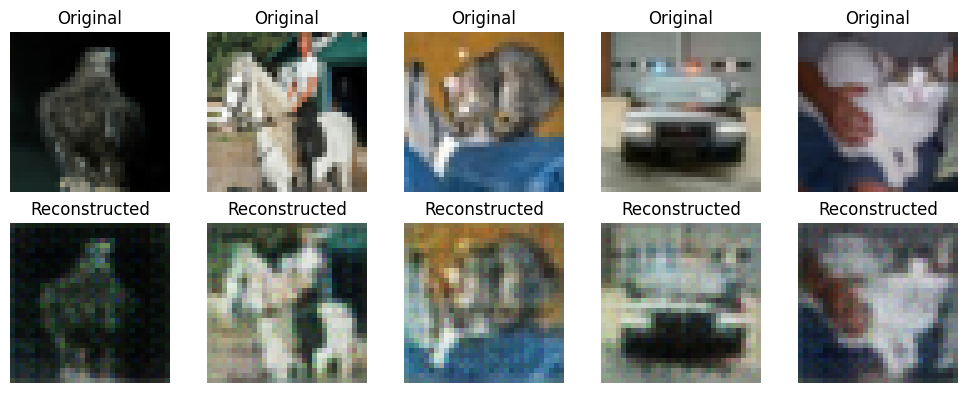

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  9/ 30  Batch:    1  Total Loss:  848.636  VQ Loss:  2.09325  Recon Loss:  846.543  Commitment Loss:  1.90295  Embedding Loss:  1.90295  LR:  8.60934e-06
Epoch:  9/ 30  Batch:  151  Total Loss:  871.589  VQ Loss:  2.08419  Recon Loss:  869.505  Commitment Loss:  1.89471  Embedding Loss:  1.89471  LR:  8.60934e-06
Epoch:  9/ 30  Batch:  301  Total Loss:  799.92  VQ Loss:  2.05857  Recon Loss:  797.862  Commitment Loss:  1.87143  Embedding Loss:  1.87143  LR:  8.60934e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       9 │          1711.72 │ 6.42s  │
╘═════════╧══════════════════╧════════╛


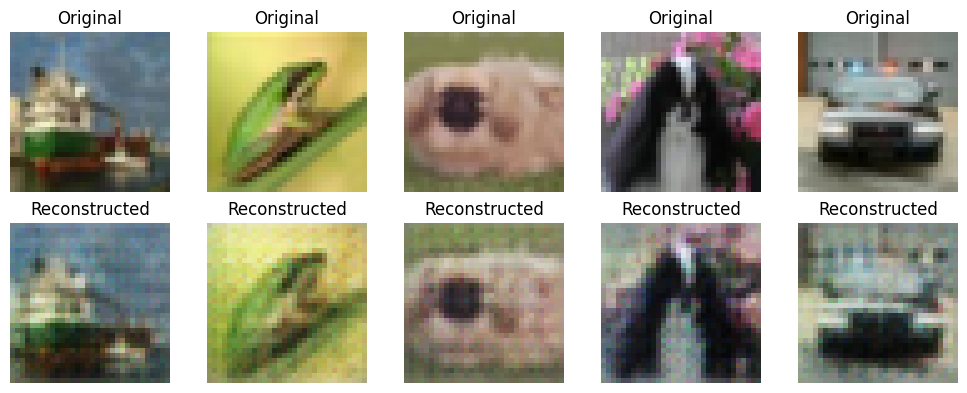

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  10/ 30  Batch:    1  Total Loss:  834.702  VQ Loss:  2.06707  Recon Loss:  832.635  Commitment Loss:  1.87916  Embedding Loss:  1.87916  LR:  7.74841e-06
Epoch:  10/ 30  Batch:  151  Total Loss:  745.707  VQ Loss:  2.05436  Recon Loss:  743.653  Commitment Loss:  1.8676  Embedding Loss:  1.8676  LR:  7.74841e-06
Epoch:  10/ 30  Batch:  301  Total Loss:  831.929  VQ Loss:  2.08824  Recon Loss:  829.841  Commitment Loss:  1.8984  Embedding Loss:  1.8984  LR:  7.74841e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      10 │           1660.2 │ 6.39s  │
╘═════════╧══════════════════╧════════╛


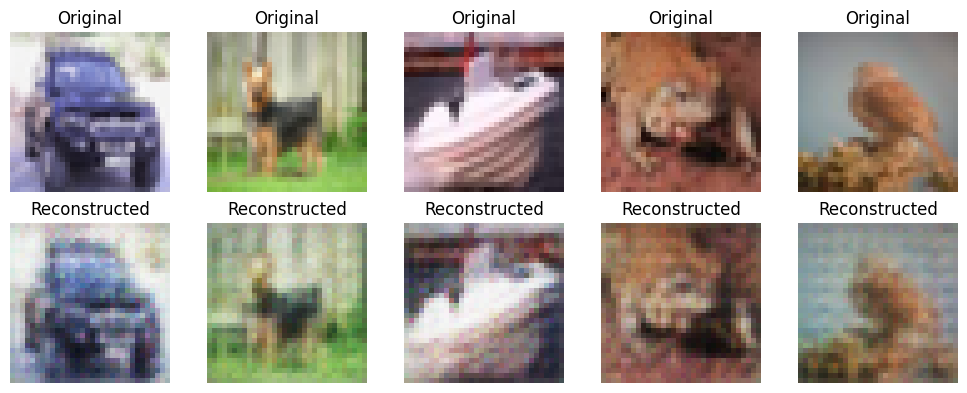

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  11/ 30  Batch:    1  Total Loss:  804.612  VQ Loss:  2.02873  Recon Loss:  802.583  Commitment Loss:  1.8443  Embedding Loss:  1.8443  LR:  6.97357e-06
Epoch:  11/ 30  Batch:  151  Total Loss:  789.207  VQ Loss:  2.04887  Recon Loss:  787.158  Commitment Loss:  1.86261  Embedding Loss:  1.86261  LR:  6.97357e-06
Epoch:  11/ 30  Batch:  301  Total Loss:  721.603  VQ Loss:  2.10779  Recon Loss:  719.495  Commitment Loss:  1.91617  Embedding Loss:  1.91617  LR:  6.97357e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      11 │          1647.86 │ 6.43s  │
╘═════════╧══════════════════╧════════╛


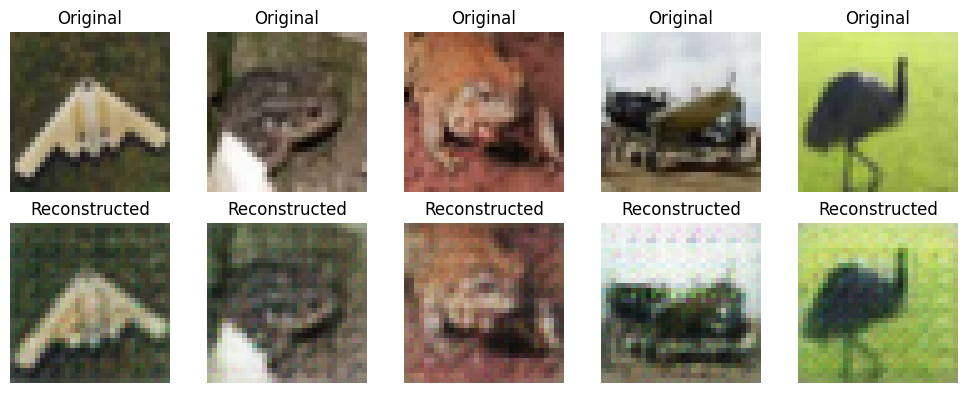

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  12/ 30  Batch:    1  Total Loss:  764.151  VQ Loss:  2.05613  Recon Loss:  762.095  Commitment Loss:  1.86921  Embedding Loss:  1.86921  LR:  6.27621e-06
Epoch:  12/ 30  Batch:  151  Total Loss:  728.202  VQ Loss:  2.05688  Recon Loss:  726.146  Commitment Loss:  1.86989  Embedding Loss:  1.86989  LR:  6.27621e-06
Epoch:  12/ 30  Batch:  301  Total Loss:  716.954  VQ Loss:  2.03657  Recon Loss:  714.917  Commitment Loss:  1.85142  Embedding Loss:  1.85142  LR:  6.27621e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      12 │          1585.58 │ 6.41s  │
╘═════════╧══════════════════╧════════╛


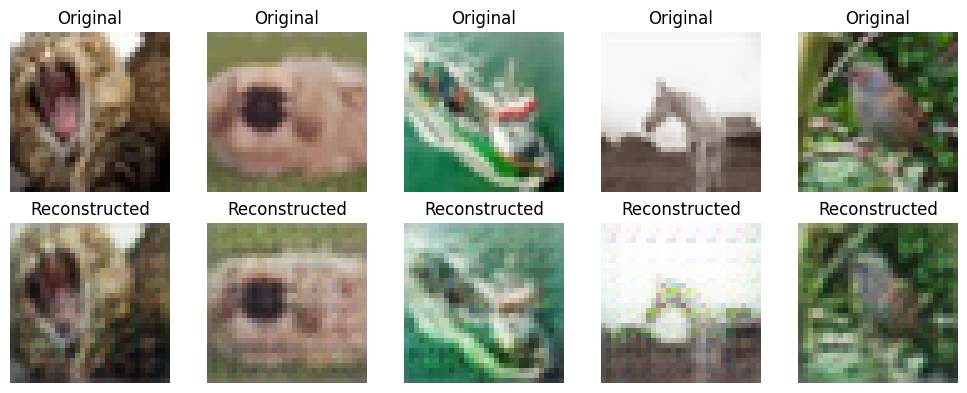

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  13/ 30  Batch:    1  Total Loss:  665.674  VQ Loss:  2.01979  Recon Loss:  663.654  Commitment Loss:  1.83617  Embedding Loss:  1.83617  LR:  5.64859e-06
Epoch:  13/ 30  Batch:  151  Total Loss:  712.845  VQ Loss:  2.06283  Recon Loss:  710.782  Commitment Loss:  1.8753  Embedding Loss:  1.8753  LR:  5.64859e-06
Epoch:  13/ 30  Batch:  301  Total Loss:  659.772  VQ Loss:  2.07435  Recon Loss:  657.698  Commitment Loss:  1.88577  Embedding Loss:  1.88577  LR:  5.64859e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      13 │          1693.15 │ 6.29s  │
╘═════════╧══════════════════╧════════╛


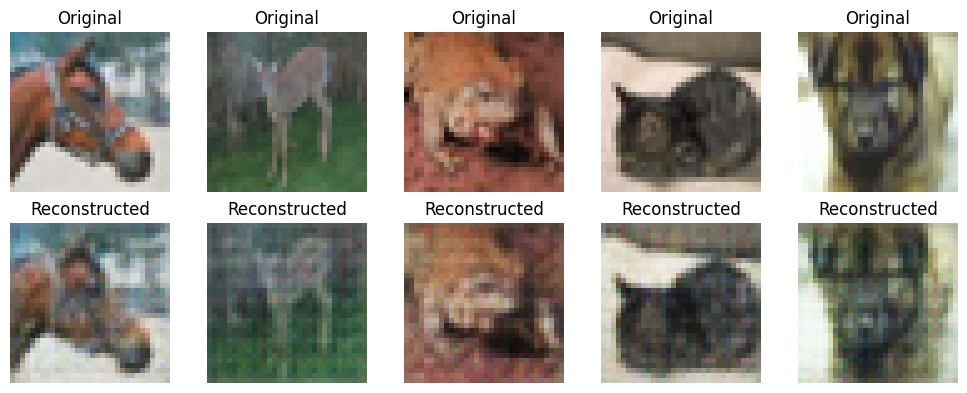

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  14/ 30  Batch:    1  Total Loss:  653.939  VQ Loss:  2.09315  Recon Loss:  651.845  Commitment Loss:  1.90286  Embedding Loss:  1.90286  LR:  5.08373e-06
Epoch:  14/ 30  Batch:  151  Total Loss:  641.777  VQ Loss:  2.05444  Recon Loss:  639.722  Commitment Loss:  1.86767  Embedding Loss:  1.86767  LR:  5.08373e-06
Epoch:  14/ 30  Batch:  301  Total Loss:  705.81  VQ Loss:  2.08184  Recon Loss:  703.728  Commitment Loss:  1.89258  Embedding Loss:  1.89258  LR:  5.08373e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      14 │          1560.81 │ 6.36s  │
╘═════════╧══════════════════╧════════╛


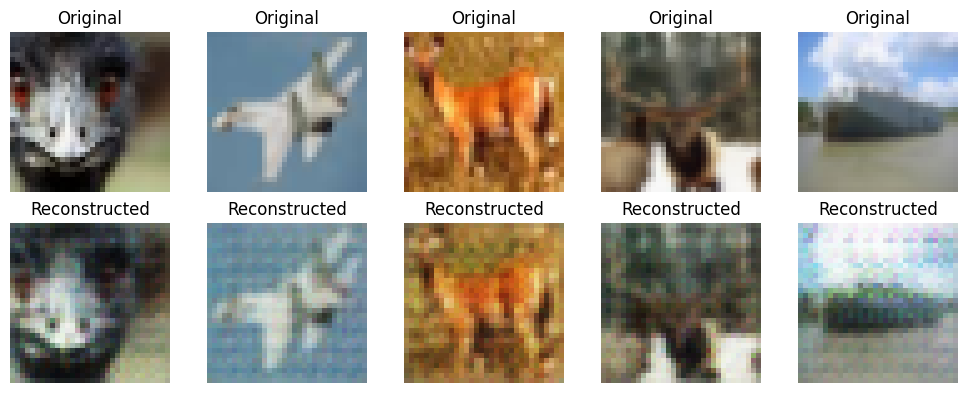

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  15/ 30  Batch:    1  Total Loss:  565.344  VQ Loss:  2.0736  Recon Loss:  563.27  Commitment Loss:  1.88509  Embedding Loss:  1.88509  LR:  4.57536e-06
Epoch:  15/ 30  Batch:  151  Total Loss:  821.942  VQ Loss:  2.0413  Recon Loss:  819.9  Commitment Loss:  1.85573  Embedding Loss:  1.85573  LR:  4.57536e-06
Epoch:  15/ 30  Batch:  301  Total Loss:  720.426  VQ Loss:  2.06195  Recon Loss:  718.364  Commitment Loss:  1.8745  Embedding Loss:  1.8745  LR:  4.57536e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      15 │          1546.69 │ 6.36s  │
╘═════════╧══════════════════╧════════╛


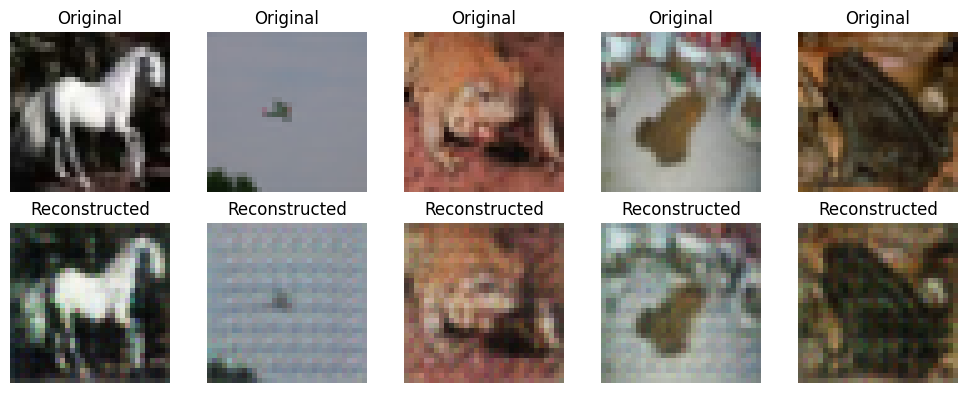

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  16/ 30  Batch:    1  Total Loss:  630.792  VQ Loss:  2.07092  Recon Loss:  628.721  Commitment Loss:  1.88266  Embedding Loss:  1.88266  LR:  4.11782e-06
Epoch:  16/ 30  Batch:  151  Total Loss:  764.697  VQ Loss:  2.06235  Recon Loss:  762.635  Commitment Loss:  1.87487  Embedding Loss:  1.87487  LR:  4.11782e-06
Epoch:  16/ 30  Batch:  301  Total Loss:  552.17  VQ Loss:  2.09299  Recon Loss:  550.077  Commitment Loss:  1.90272  Embedding Loss:  1.90272  LR:  4.11782e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      16 │          1581.84 │ 6.45s  │
╘═════════╧══════════════════╧════════╛


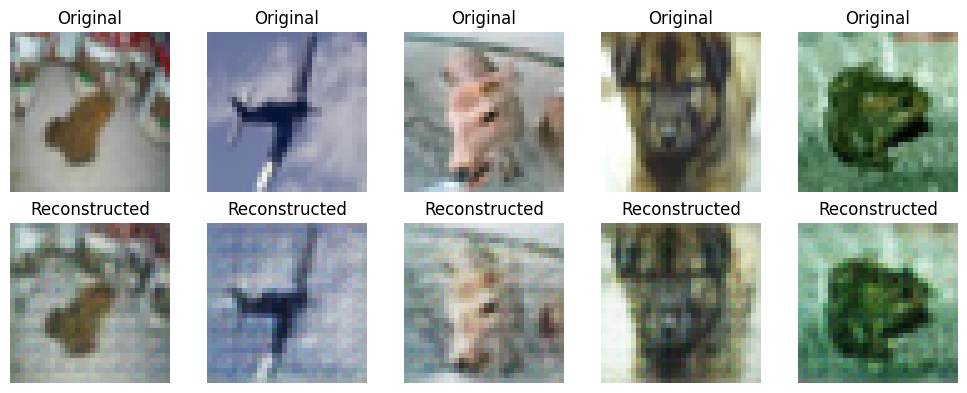

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  17/ 30  Batch:    1  Total Loss:  658.601  VQ Loss:  2.08052  Recon Loss:  656.52  Commitment Loss:  1.89138  Embedding Loss:  1.89138  LR:  3.70604e-06
Epoch:  17/ 30  Batch:  151  Total Loss:  616.851  VQ Loss:  2.07146  Recon Loss:  614.78  Commitment Loss:  1.88315  Embedding Loss:  1.88315  LR:  3.70604e-06
Epoch:  17/ 30  Batch:  301  Total Loss:  602.809  VQ Loss:  2.0806  Recon Loss:  600.729  Commitment Loss:  1.89145  Embedding Loss:  1.89145  LR:  3.70604e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      17 │          1496.44 │ 6.48s  │
╘═════════╧══════════════════╧════════╛


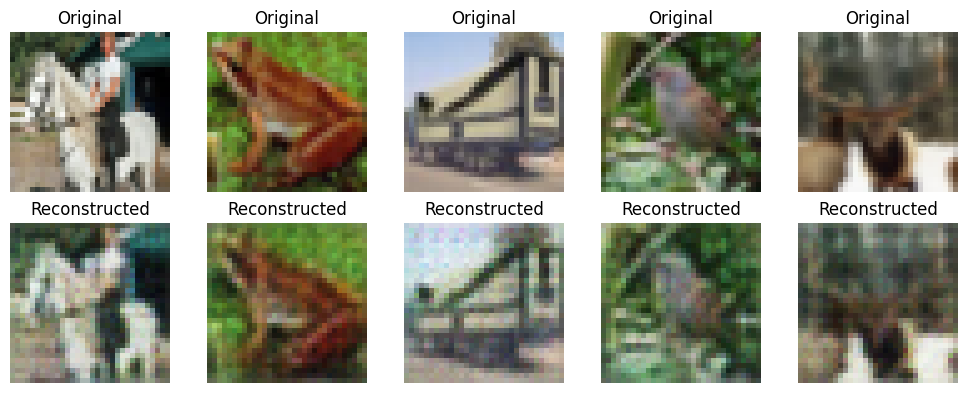

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  18/ 30  Batch:    1  Total Loss:  668.723  VQ Loss:  2.06576  Recon Loss:  666.657  Commitment Loss:  1.87796  Embedding Loss:  1.87796  LR:  3.33544e-06
Epoch:  18/ 30  Batch:  151  Total Loss:  566.388  VQ Loss:  2.03395  Recon Loss:  564.354  Commitment Loss:  1.84905  Embedding Loss:  1.84905  LR:  3.33544e-06
Epoch:  18/ 30  Batch:  301  Total Loss:  610.285  VQ Loss:  2.05183  Recon Loss:  608.234  Commitment Loss:  1.86529  Embedding Loss:  1.86529  LR:  3.33544e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      18 │          1529.34 │ 6.45s  │
╘═════════╧══════════════════╧════════╛


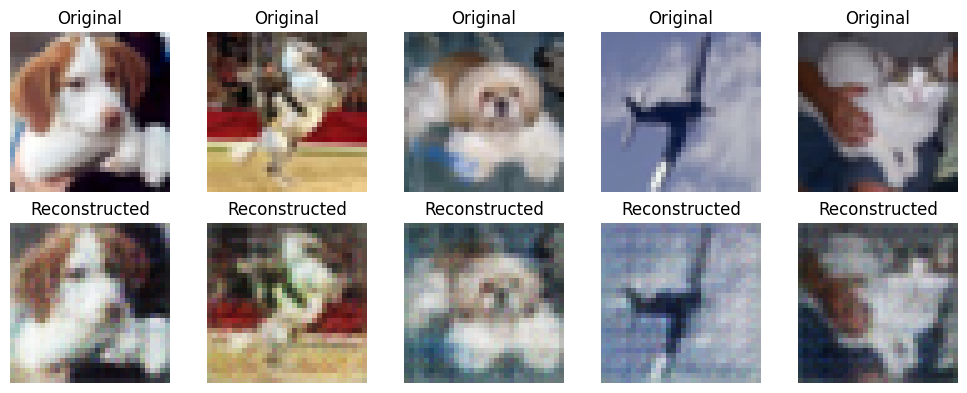

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  19/ 30  Batch:    1  Total Loss:  579.58  VQ Loss:  2.04716  Recon Loss:  577.533  Commitment Loss:  1.86105  Embedding Loss:  1.86105  LR:  3.00189e-06
Epoch:  19/ 30  Batch:  151  Total Loss:  713.794  VQ Loss:  2.08173  Recon Loss:  711.712  Commitment Loss:  1.89248  Embedding Loss:  1.89248  LR:  3.00189e-06
Epoch:  19/ 30  Batch:  301  Total Loss:  538.998  VQ Loss:  2.03039  Recon Loss:  536.968  Commitment Loss:  1.84581  Embedding Loss:  1.84581  LR:  3.00189e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      19 │          1531.83 │ 6.42s  │
╘═════════╧══════════════════╧════════╛


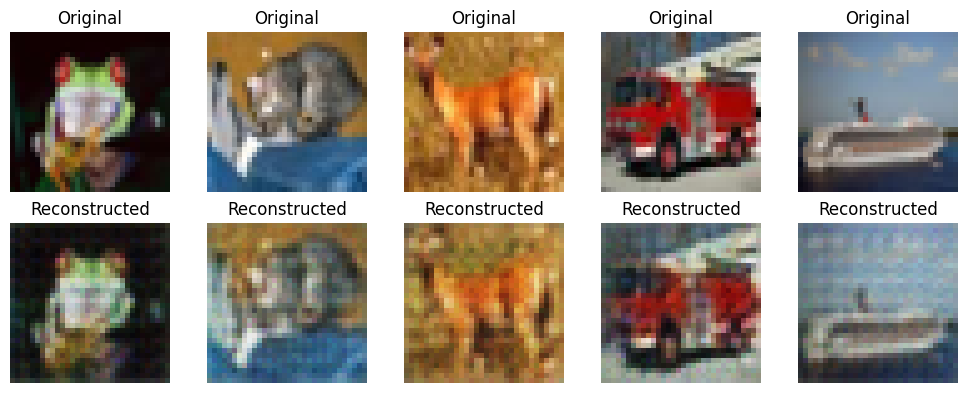

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  20/ 30  Batch:    1  Total Loss:  632.573  VQ Loss:  2.06637  Recon Loss:  630.506  Commitment Loss:  1.87852  Embedding Loss:  1.87852  LR:  2.7017e-06
Epoch:  20/ 30  Batch:  151  Total Loss:  591.937  VQ Loss:  2.06397  Recon Loss:  589.873  Commitment Loss:  1.87634  Embedding Loss:  1.87634  LR:  2.7017e-06
Epoch:  20/ 30  Batch:  301  Total Loss:  558.594  VQ Loss:  2.06732  Recon Loss:  556.527  Commitment Loss:  1.87938  Embedding Loss:  1.87938  LR:  2.7017e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      20 │          1521.12 │ 6.30s  │
╘═════════╧══════════════════╧════════╛


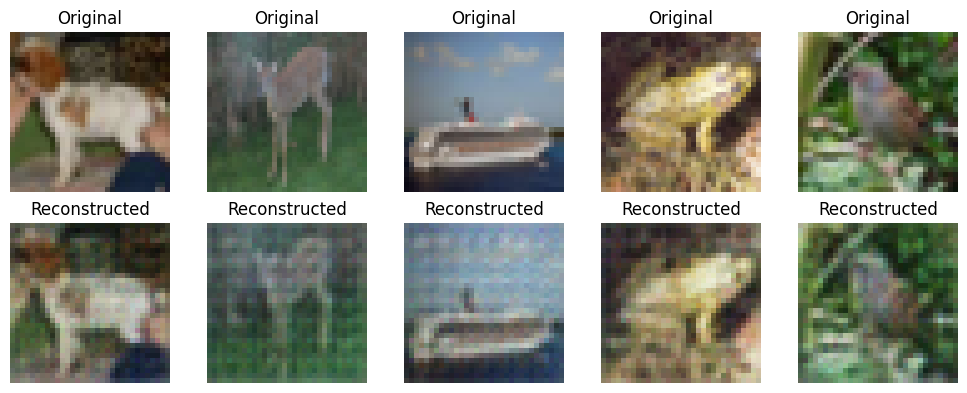

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  21/ 30  Batch:    1  Total Loss:  597.391  VQ Loss:  2.05205  Recon Loss:  595.339  Commitment Loss:  1.86549  Embedding Loss:  1.86549  LR:  2.43153e-06
Epoch:  21/ 30  Batch:  151  Total Loss:  680.108  VQ Loss:  2.06161  Recon Loss:  678.046  Commitment Loss:  1.87419  Embedding Loss:  1.87419  LR:  2.43153e-06
Epoch:  21/ 30  Batch:  301  Total Loss:  602.41  VQ Loss:  2.08412  Recon Loss:  600.326  Commitment Loss:  1.89466  Embedding Loss:  1.89466  LR:  2.43153e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      21 │          1459.83 │ 6.45s  │
╘═════════╧══════════════════╧════════╛


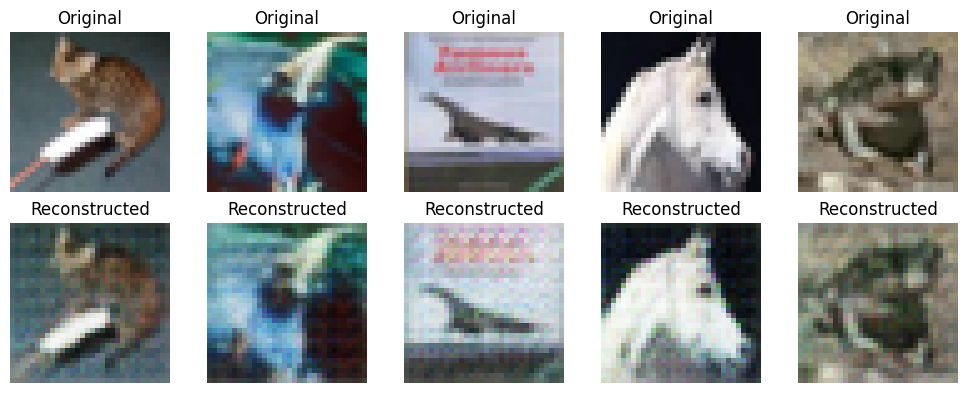

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  22/ 30  Batch:    1  Total Loss:  570.096  VQ Loss:  2.05883  Recon Loss:  568.037  Commitment Loss:  1.87166  Embedding Loss:  1.87166  LR:  2.18838e-06
Epoch:  22/ 30  Batch:  151  Total Loss:  606.427  VQ Loss:  2.07417  Recon Loss:  604.353  Commitment Loss:  1.88561  Embedding Loss:  1.88561  LR:  2.18838e-06
Epoch:  22/ 30  Batch:  301  Total Loss:  716.696  VQ Loss:  2.05827  Recon Loss:  714.637  Commitment Loss:  1.87116  Embedding Loss:  1.87116  LR:  2.18838e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      22 │          1443.47 │ 6.37s  │
╘═════════╧══════════════════╧════════╛


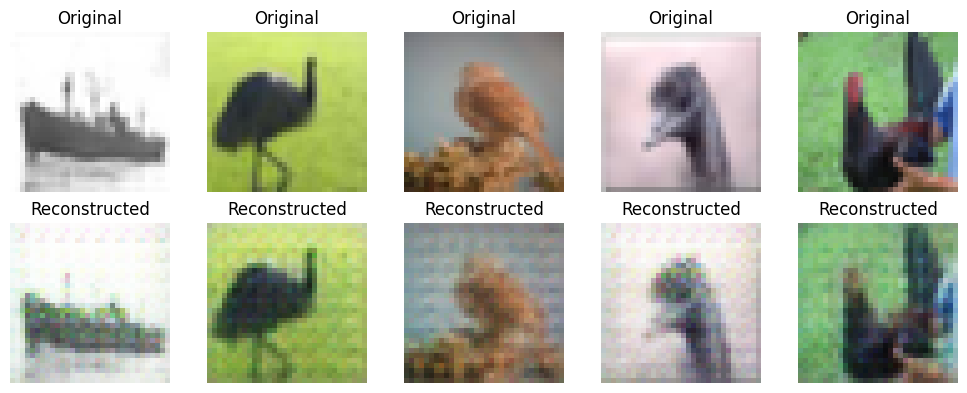

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  23/ 30  Batch:    1  Total Loss:  542.328  VQ Loss:  2.06507  Recon Loss:  540.263  Commitment Loss:  1.87734  Embedding Loss:  1.87734  LR:  1.96954e-06
Epoch:  23/ 30  Batch:  151  Total Loss:  494.432  VQ Loss:  2.03785  Recon Loss:  492.394  Commitment Loss:  1.85259  Embedding Loss:  1.85259  LR:  1.96954e-06
Epoch:  23/ 30  Batch:  301  Total Loss:  625.431  VQ Loss:  2.06435  Recon Loss:  623.366  Commitment Loss:  1.87668  Embedding Loss:  1.87668  LR:  1.96954e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      23 │          1457.65 │ 6.34s  │
╘═════════╧══════════════════╧════════╛


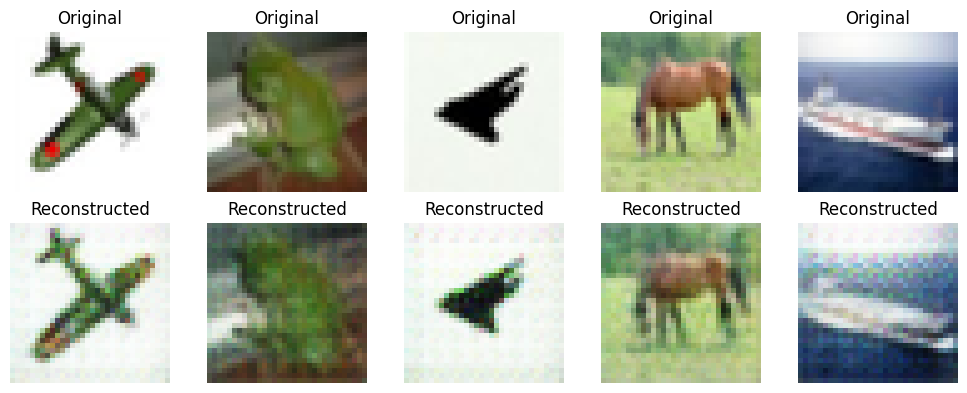

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  24/ 30  Batch:    1  Total Loss:  600.881  VQ Loss:  2.05779  Recon Loss:  598.824  Commitment Loss:  1.87072  Embedding Loss:  1.87072  LR:  1.77259e-06
Epoch:  24/ 30  Batch:  151  Total Loss:  593.763  VQ Loss:  2.06155  Recon Loss:  591.701  Commitment Loss:  1.87414  Embedding Loss:  1.87414  LR:  1.77259e-06
Epoch:  24/ 30  Batch:  301  Total Loss:  518.162  VQ Loss:  2.07166  Recon Loss:  516.09  Commitment Loss:  1.88332  Embedding Loss:  1.88332  LR:  1.77259e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      24 │          1434.29 │ 6.47s  │
╘═════════╧══════════════════╧════════╛


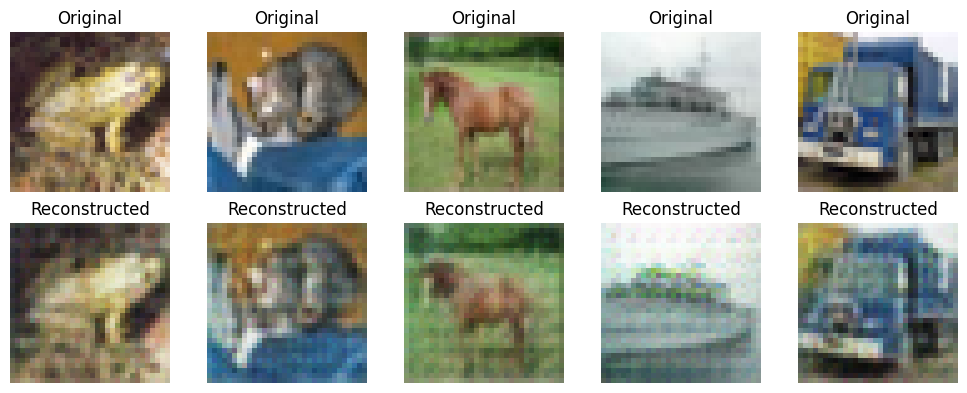

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  25/ 30  Batch:    1  Total Loss:  552.501  VQ Loss:  2.037  Recon Loss:  550.464  Commitment Loss:  1.85182  Embedding Loss:  1.85182  LR:  1.59533e-06
Epoch:  25/ 30  Batch:  151  Total Loss:  550.745  VQ Loss:  2.07708  Recon Loss:  548.668  Commitment Loss:  1.88825  Embedding Loss:  1.88825  LR:  1.59533e-06
Epoch:  25/ 30  Batch:  301  Total Loss:  602.688  VQ Loss:  2.06382  Recon Loss:  600.624  Commitment Loss:  1.8762  Embedding Loss:  1.8762  LR:  1.59533e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      25 │          1449.39 │ 6.30s  │
╘═════════╧══════════════════╧════════╛


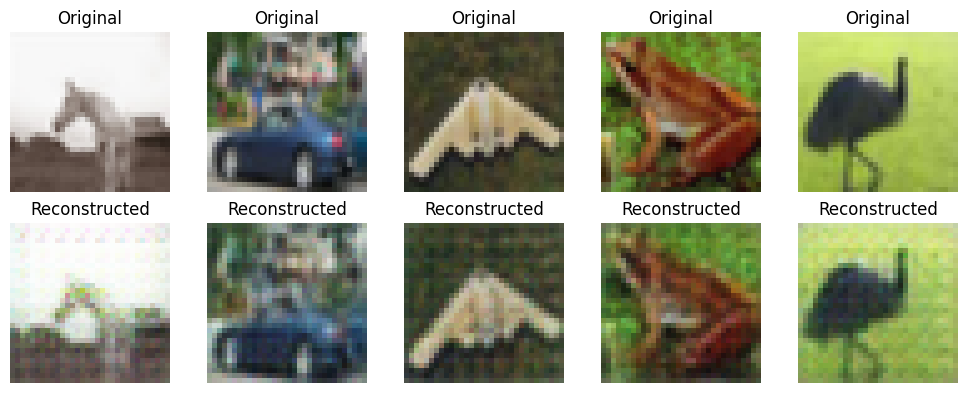

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  26/ 30  Batch:    1  Total Loss:  622.207  VQ Loss:  2.05568  Recon Loss:  620.151  Commitment Loss:  1.8688  Embedding Loss:  1.8688  LR:  1.4358e-06
Epoch:  26/ 30  Batch:  151  Total Loss:  675.509  VQ Loss:  2.05346  Recon Loss:  673.456  Commitment Loss:  1.86678  Embedding Loss:  1.86678  LR:  1.4358e-06
Epoch:  26/ 30  Batch:  301  Total Loss:  594.748  VQ Loss:  2.06731  Recon Loss:  592.681  Commitment Loss:  1.87938  Embedding Loss:  1.87938  LR:  1.4358e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      26 │          1495.57 │ 6.35s  │
╘═════════╧══════════════════╧════════╛


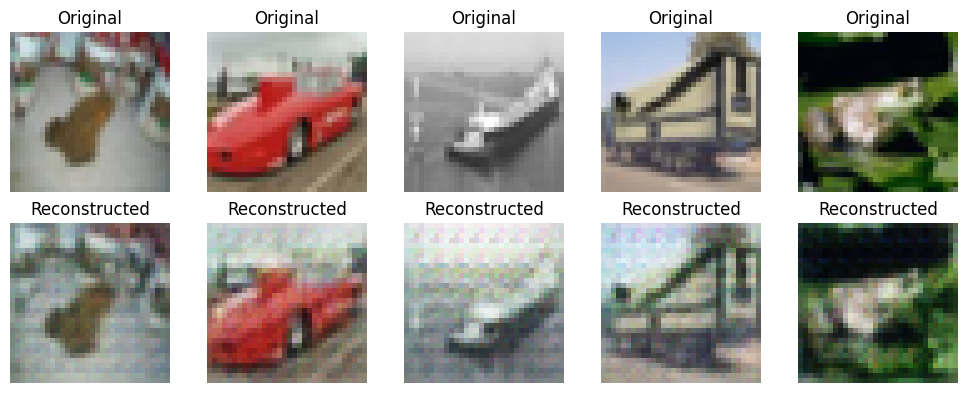

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  27/ 30  Batch:    1  Total Loss:  594.553  VQ Loss:  2.05724  Recon Loss:  592.496  Commitment Loss:  1.87022  Embedding Loss:  1.87022  LR:  1.29222e-06
Epoch:  27/ 30  Batch:  151  Total Loss:  520.758  VQ Loss:  2.08923  Recon Loss:  518.669  Commitment Loss:  1.8993  Embedding Loss:  1.8993  LR:  1.29222e-06
Epoch:  27/ 30  Batch:  301  Total Loss:  621.868  VQ Loss:  2.05021  Recon Loss:  619.817  Commitment Loss:  1.86382  Embedding Loss:  1.86382  LR:  1.29222e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      27 │          1433.11 │ 6.53s  │
╘═════════╧══════════════════╧════════╛


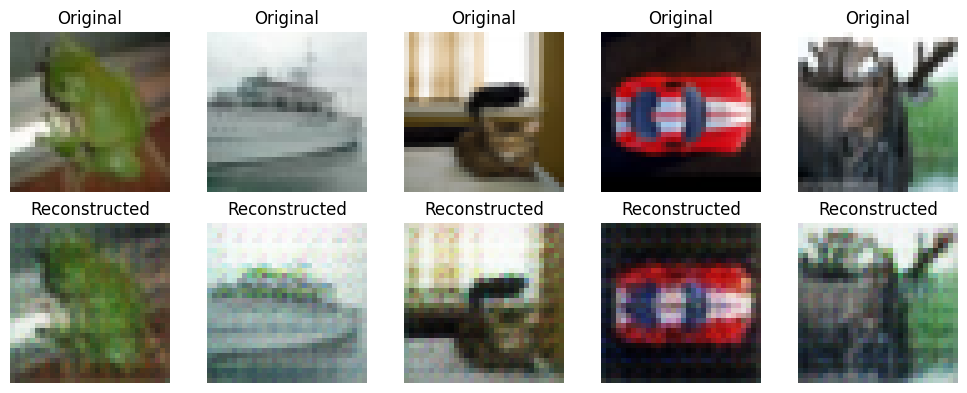

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  28/ 30  Batch:    1  Total Loss:  517.725  VQ Loss:  2.06807  Recon Loss:  515.656  Commitment Loss:  1.88006  Embedding Loss:  1.88006  LR:  1.16299e-06
Epoch:  28/ 30  Batch:  151  Total Loss:  484.9  VQ Loss:  2.05379  Recon Loss:  482.846  Commitment Loss:  1.86708  Embedding Loss:  1.86708  LR:  1.16299e-06
Epoch:  28/ 30  Batch:  301  Total Loss:  615.967  VQ Loss:  2.05062  Recon Loss:  613.916  Commitment Loss:  1.8642  Embedding Loss:  1.8642  LR:  1.16299e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      28 │           1460.2 │ 6.51s  │
╘═════════╧══════════════════╧════════╛


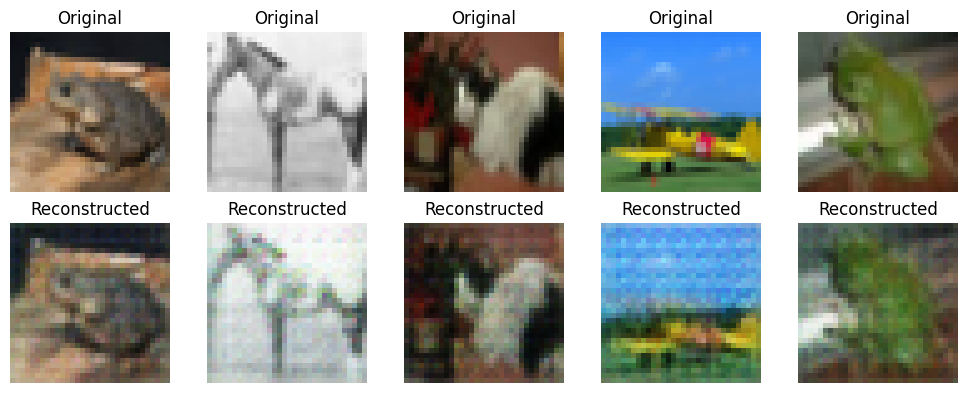

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  29/ 30  Batch:    1  Total Loss:  557.026  VQ Loss:  2.066  Recon Loss:  554.96  Commitment Loss:  1.87818  Embedding Loss:  1.87818  LR:  1.0467e-06
Epoch:  29/ 30  Batch:  151  Total Loss:  518.245  VQ Loss:  2.02515  Recon Loss:  516.219  Commitment Loss:  1.84105  Embedding Loss:  1.84105  LR:  1.0467e-06
Epoch:  29/ 30  Batch:  301  Total Loss:  610.281  VQ Loss:  2.07629  Recon Loss:  608.205  Commitment Loss:  1.88753  Embedding Loss:  1.88753  LR:  1.0467e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      29 │          1460.74 │ 6.36s  │
╘═════════╧══════════════════╧════════╛


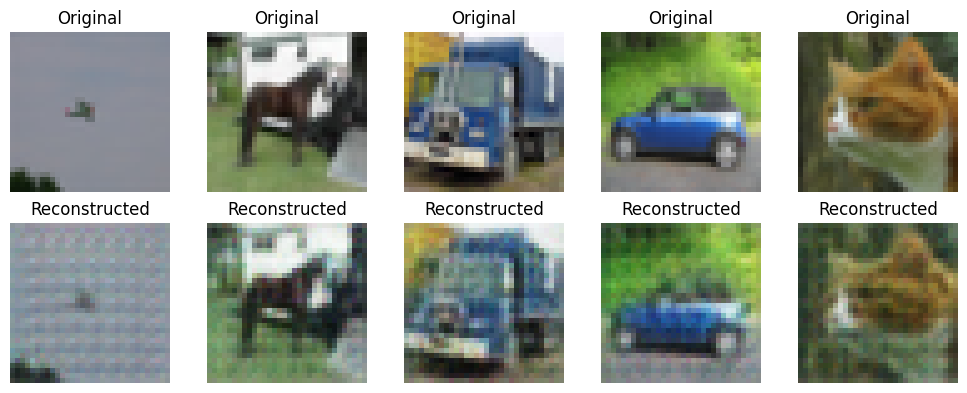

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  30/ 30  Batch:    1  Total Loss:  550.632  VQ Loss:  2.02265  Recon Loss:  548.61  Commitment Loss:  1.83877  Embedding Loss:  1.83877  LR:  9.42026e-07
Epoch:  30/ 30  Batch:  151  Total Loss:  656.621  VQ Loss:  2.062  Recon Loss:  654.559  Commitment Loss:  1.87454  Embedding Loss:  1.87454  LR:  9.42026e-07
Epoch:  30/ 30  Batch:  301  Total Loss:  686.273  VQ Loss:  2.05523  Recon Loss:  684.218  Commitment Loss:  1.86839  Embedding Loss:  1.86839  LR:  9.42026e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      30 │           1402.9 │ 6.30s  │
╘═════════╧══════════════════╧════════╛


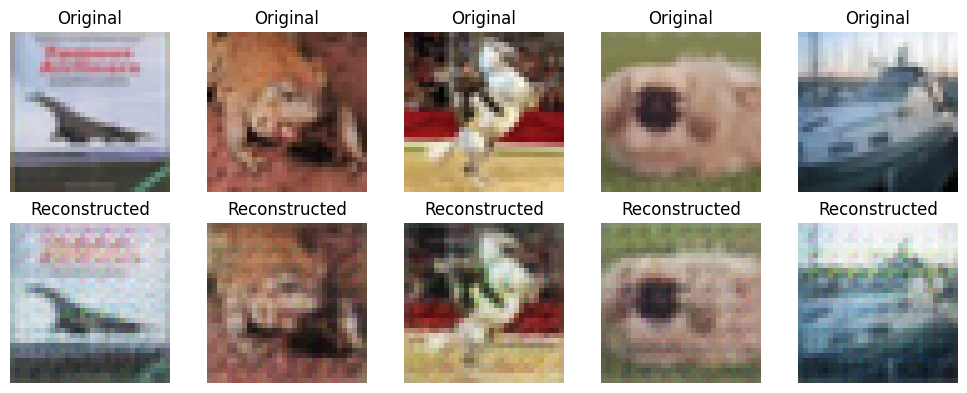

-----------------------------------------------------------------------------------------------------------------------------


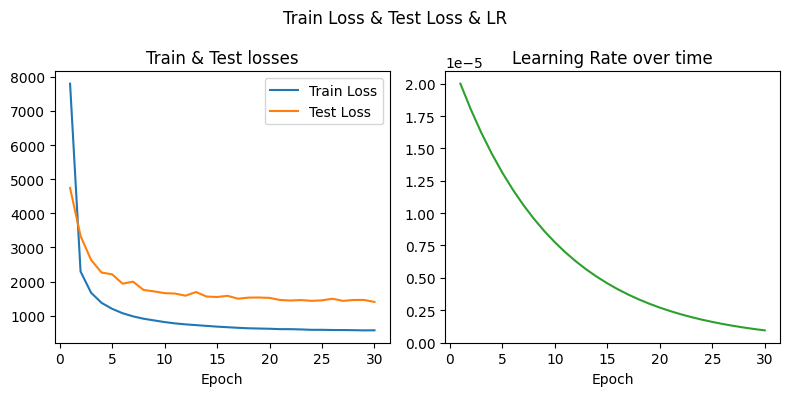

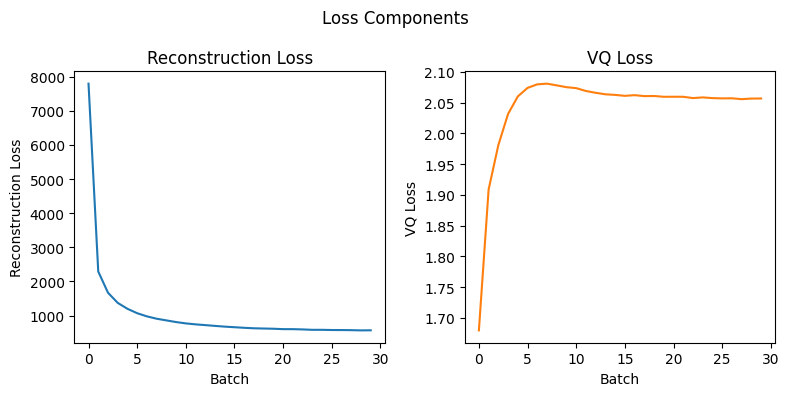

In [4]:
# Suppress user warnings
warnings.filterwarnings("ignore")

# Initialize lists for tracking losses and learning rates
train_losses = []
test_losses = []
learning_rates = []
reconstruction_losses = []
vq_losses = []
commitment_losses = []
embedding_losses = []

# Training loop
for epoch in range(num_epochs):
    print('-----------------------------------------------------------------------------------------------------------------------------')
    model.train()

    batch_recon_losses = []
    batch_vq_losses = []
    batch_total_losses = []

    epoch_start_time = time.time()  # Start of time measurement

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            # Forward pass
            recon_batch, vqloss, embedding_loss, commitment_loss = model(data)

            # Compute loss
            loss, recon_loss, _  = loss_function(recon_batch, data, vqloss)

        # Backward pass
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        # Save the loss values for the current batch
        curr_loss = loss.detach().item()
        curr_vqloss = vqloss.detach().item()
        curr_recon_loss = recon_loss.detach().item()
        curr_commitment_loss = commitment_loss.detach().item()
        curr_embedding_loss = embedding_loss.detach().item()
        batch_total_losses.append(curr_loss)
        batch_vq_losses.append(curr_vqloss)
        batch_recon_losses.append(curr_recon_loss)

        # Log training loss and current learning rate
        if batch_idx % output_frequency == 0:
            log = [['Epoch:', f'{epoch + 1:3d}/{num_epochs:3d}', 'Batch:', f'{batch_idx + 1:3d}',
                    'Total Loss:', f'{curr_loss:.6f}', 'VQ Loss:', f'{curr_vqloss:.6f}',
                    'Recon Loss:', f'{curr_recon_loss:.6f}',
                    'Commitment Loss:', f'{curr_commitment_loss:.6f}',
                    'Embedding Loss:', f'{curr_embedding_loss:.6f}',
                    'LR:', scheduler.get_last_lr()[0]]]
            print(tabulate(log, tablefmt="plain"))

    # Step the learning rate scheduler
    if scheduler is not None:
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
    else:
        lr = learning_rate
    learning_rates.append(lr)

    # After the epoch, evaluate the accuracy on the test dataset
    mean_loss = evaluate(model, test_loader, loss_function, device)
    test_losses.append(mean_loss)

    # Save the average loss values
    average_total_loss = torch.tensor(batch_total_losses).mean().item()
    average_recon_loss = torch.tensor(batch_recon_losses).mean().item()
    average_vq_loss = torch.tensor(batch_vq_losses).mean().item()

    train_losses.append(average_total_loss)
    reconstruction_losses.append(average_recon_loss)
    vq_losses.append(average_vq_loss)

    # End of time measurement
    elapsed_time = time.time() - epoch_start_time

    # Log epoch results
    headers = ["Epoch", "Mean Test Loss", "Time"]
    data = [[epoch + 1, f"{mean_loss:.4f}", f"{elapsed_time:.2f}s"]]
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

    # Generate reconstructed test images after each epoch
    plot_reconstruction(model, test_loader, device, num_samples=5)
    print('-----------------------------------------------------------------------------------------------------------------------------')

# Plot Train Loss & Test Loss & LR
plot_loss_lr(num_epochs, train_losses, test_losses, learning_rates)

# Plot each loss component
plot_loss_components(reconstruction_losses, vq_losses)

## Vector interpolation

In [6]:
# Create a video  of images that show the interpolation on a linear trajectory between z1 and z2
images, _ = next(iter(test_loader))
z1 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
z2 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
interpolate(z1, z2, model, steps=200)

Interpolation video saved as output/interpolation.avi.
